# 5 Computational Performance: GraphFrames vs igraph

## 5.0.1 Introduction and Setup

In [1]:
from graphframes import *
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Since the test runtimes were conducted on different machines and in different environments (R igraph running locally on Device A, Scala GraphFrames running on a Virtual Machine on Device B), the saved runtimes that we had are difficult to compare effectively. This section of the report focuses on using PySpark GraphFrames (run on Jupyter Lab on Device C) to compare with igraph also run on Jupyter Lab on Device C. 

However, before jumping into runtimes, we briefly explore how the GraphFrame module works with PySpark and develop understanding of how our graphs are constructed to run our algorithms on.

Note: If you run this code and want to keep comparing runtimes as on your own machine, you will need to run the code in the Appendix first. The section where this becomes particularly relevant is highlighted later on.

In [2]:
#initialise sparkContext and set checkpoint 
sc = spark.sparkContext
sc.setCheckpointDir('times_cps')

In [3]:
#number of nodes that correspond to our ER graphs
nodes = [10,32, 100, 316, 1000, 3162, 10000]

In [43]:
#we check if this zip method works for printing our number of nodes
#and zipping 1 and 2 to each node
for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
    print(n,i)

10 1
32 2
100 1
316 2
1000 1
3162 2
10000 1
10 2
32 1
100 2
316 1
1000 2
3162 1
10000 2


## 5.0.2 Loading in Graph Connection CSVs

In [5]:
#create empty dataframe for edge counts
edge_df = pd.DataFrame(columns=['p1','p2'],index=nodes)
edge_df.index.name = 'nodes'

#created our zipped list as above and loop through it
for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
    #set path to grab correct edges csv e.g. 'G_ 100 _p1'
    path = '../Data/G_ ' + str(n) + ' _p' + str(i)
    edges = spark.read.csv(path,header=True)
    #rename to match the 'src' and 'dst format that spark prefers, drop index col '_c0'
    edges = edges.withColumnRenamed('V1','src').withColumnRenamed('V2','dst').drop('_c0')
    #create a list of ids; these are the vertices for our erdos-renyi graphs
    ids = list(range(1,n+1))
    #assign vertices to ids
    vertices = spark.createDataFrame(ids, IntegerType()).withColumnRenamed('value','id')
    #store above variables under appropriate name, e.g. p1_10_e for G_10_p1 edges etc
    locals()['p{}_{}_e'.format(i,n)] = edges
    locals()['p{}_{}_v'.format(i,n)] = vertices
    
    #retrieve edge count and assign it to dataframe
    edge_df.loc[n][i-1] = edges.count()
    
    
#delete our temp vars
del edges
del ids
del vertices

We take a look at our edge_df dataframe below

In [6]:
edge_df

,p1,p2
nodes,,
10,4,13
32,42,59
100,225,233
316,777,1021
1000,3105,3780
3162,11479,13918
10000,41996,50201


## 5.0.3 Constructing Graphs and Checking Implementation with GraphFrames

We now preview our edges and vertices spark dataframes before constructing graphs objects out of them. We plot the graphs and we perform sanity checks to see that our GraphFrame implementation is running correctly.

In [7]:
#preview vertices for graph with 10 nodes and connection prob p1=0.15
p1_10_v.show()

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
+---+



In [8]:
#preview edges 
p1_10_e.show()

+---+---+
|src|dst|
+---+---+
|  1|  5|
|  2|  5|
|  3|  8|
|  7| 10|
+---+---+



In [9]:
#create g1_10 corresponding to the p1_10 vertices/edges framework above 
g1_10 = GraphFrame(v=p1_10_v, e=p1_10_e)
#find what components/communities each vertex/node belongs in
g1_10.connectedComponents().show()

+---+---------+
| id|component|
+---+---------+
|  1|        1|
|  2|        1|
|  3|        3|
|  4|        4|
|  5|        1|
|  6|        6|
|  7|        7|
|  8|        3|
|  9|        9|
| 10|        7|
+---+---------+



Having constructed our graph above, we now calculate the number of components in the graph to see if it is connected or not (if number of components == 1, then the graph is fully connected).

In [10]:
#function for calculating num of communities
#this is in a separate cell so that the magic %%time function in the next cell works correctly
def countComps(graph):
    return graph.connectedComponents().select('component').distinct().count()

In [11]:
%%time
#select the 'component' column above and count distinct elements
#this is what we want to measure the time performance of
countComps(g1_10)

Wall time: 11.5 s


6

We seem to have 6 connected communities in this particular graph. We plot the graph as a sanity check to confirm this and everything else that we saw previously. The code from this is adapted from this [stackoverflow post](https://stackoverflow.com/questions/54204062/how-to-display-visualize-a-graph-created-by-graphframe).

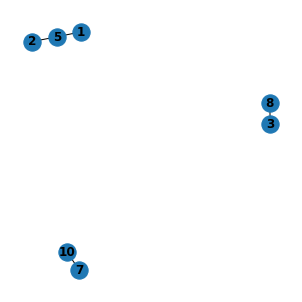

In [12]:
#define plotting function
def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(212384):
        Gplot.add_edge(row['src'],row['dst'])

        
    fig = plt.figure(figsize=(4,4))
    nx.draw(Gplot, with_labels=True, font_weight='bold')

#plot graph
PlotGraph(g1_10.edges)

As we can see, there are 3 communities over 7 of our vertices. However, that means 3 of our vertices are not connected to any other vertices, therefore, they form their own communities. This gives us a total of 6 connected components as we found above.

We further look at number of edges to check that this is working as intended. We do not check number of vertices because we have explicitly constructed these, whereas edges were random.

In [13]:
edge_df.loc[10][0]

4

Now we create all the remaining graphs and run our countComps function on them all

In [14]:
#loop over (nodes,[1,2]) to create respective graphs
for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
    edges = locals()['p{}_{}_e'.format(i,n)]
    vertices = locals()['p{}_{}_v'.format(i,n)]
    #assign graphframe object to appropriately named variable
    locals()['g{}_{}'.format(i,n)] = GraphFrame(v=vertices,e=edges)

## 5.0.4 Calculating PySpark Runtime

### 5.0.4.1 All Runtimes in Single Notebook

Here, we try to time all our runtimes at once in this same single Notebook. Without jumping ahead too much, we mention now that this did not work too well.

For time recording of the functions, we use `%timeit%` instead of `%%time` so that we can store the results.

One thing that needs to be pointed out here, though, is that as the kernel runs for longer and more variables are stored, the runtimes seem to increase. What the main driver is for this (number of runs already made; number of variabless saved; or something else) is not something that we have clarified, but it's also something that's outside of the scope of this work. It suffices to note that the same function run on the same graph (in this case `countComps(g1_10)` typically takes 10-11s on initial runs but after multiple changes and cells run, this can take up to 34-36s. We did not try actively to keep recreating this and to find out the reason for it as there was not enough time to do so.

However, we do not just brush this off as, in a realistic scenario, if we had to run multiple graph analyses this issue would persist and so we keep it here since we did the same for R.

We loop over all our graphs below and count the number of communities in each, storing the runtime required for these computations.

We ran the code below to calculate and store our runtimes but an error is thrown back to us

In [15]:
# #loop to record times
# for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
#     graph = locals()['g{}_{}'.format(i,n)]
#     #run for 2 loops (-n2), 2 runs (-r2), and save results (-o)
#     result = %timeit -n2 -r2 -o countComps(graph)
#     locals()['r{}_{}'.format(i,n)] = result
    
#     del result

> `11.2 s ± 267 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`15.2 s ± 824 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`20.6 s ± 1.44 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`23.9 s ± 2.3 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`28.3 s ± 4.24 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`35 s ± 7.48 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`1min ± 15.4 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`12.1 s ± 837 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`19.6 s ± 606 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`22.3 s ± 1.5 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`58.8 s ± 6.5 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`1min 12s ± 7.14 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`2min 27s ± 2.89 s per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
`ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host`

This is the corresponding error: annoyingly 13 out of the 14 results run before running a *WinError 10054* which according to this [stackoverflow post](https://stackoverflow.com/questions/8814802/python-errno-10054-an-existing-connection-was-forcibly-closed-by-the-remote-h) results from a server closing due to long runtime. This seems to be more related to apache.spark than anything in our case and retrying/restarting the connection did not work for this.

Below we try to view the results and see what result is missing:

In [16]:
for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
    try:
        print(locals()['r{}_{}'.format(i,n)])
    except Exception as e:
        print('Error var',e)

Error var 'r1_10'
Error var 'r2_32'
Error var 'r1_100'
Error var 'r2_316'
Error var 'r1_1000'
Error var 'r2_3162'
Error var 'r1_10000'
Error var 'r2_10'
Error var 'r1_32'
Error var 'r2_100'
Error var 'r1_316'
Error var 'r2_1000'
Error var 'r1_3162'
Error var 'r2_10000'


If we try running just the code below for this time alone, we get a similar but related error:

In [17]:
# r2_10000 = %timeit -n2 -r2 -o countComps(g2_10000)

>`[WinError 10061] No connection could be made because the target machine actively refused it`

We decide that it's probably best to calculate runtimes in individual Notebooks and save outputs as CSV to compare together here. So we take that approach and we leave the notebooks in the Appendix as it is almost identical to the code above with the exception or running for `p1` in one Notebook and running for `p2` in the other.

Instead, we extract the mean and standard deviations of our times in a list to create a DataFrame so that we can store and save what the results were for this attempt for later comparison with the individual notebook runs.

The code below relies on running the above code, facing the error, then running this upcoming code to save a dataframe, then restarting kernel. Overall, this is a hassle for the reader and so instead we comment it out and supply the relevant `partial_times.csv` in `../Data/partial_times.csv`.

In [18]:
# times_lst = []
# for n,i in list(zip(2*nodes, [1,2]*len(nodes)*2)):
#     try:
#         times_lst.append((i,n, str(locals()['r{}_{}'.format(i,n)])))
#     except: #skip r2_10000
#         pass

In [19]:
# #preview of single entry to get an idea of the output
# times_lst[0]

In [20]:
# #function to extract mean
# def getMean(ts):
#     splt =  ts.split('±')[0].split(' ')[0:2]
#     #if time in seconds, we dont need to do anything 
#     if splt[1] == 's':
#         time = splt[0]
#         return time 
#     else: #if time is 1min 10s for example
#         mins = splt[0][0] #take the number before 'min'
#         try: #in case full minutes e.g. 1min and no seconds
#             secs = float(splt[1][:-1]) #take everything except the 's'
#         except:
#             secs = 0
#         time = int(mins)*60 + int(secs) #convert to seconds
#         return time

In [21]:
# #code to get standard deviation
# def getSD(ts):
#     splt = ts.split('±')[1].split(' ')[1:3]
#     if splt[1] == 'ms':
#         #convert ms to s
#         time = float(splt[0])/1000
#         return time
#     else:
#         time = splt[0]
#         return time

In [22]:
# times_dict = {}
# times_dict['p'] = [i for i,n,ts in times_lst]
# times_dict['nodes'] = [n for i,n,ts in times_lst]
# times_dict['mean'] = [getMean(ts) for i,n,ts in times_lst]
# times_dict['sd'] = [getSD(ts) for i,n,ts in times_lst]

In [23]:
# times_df = pd.DataFrame(data=times_dict)
# times_df.sort_values(by=['p','nodes'])

In [24]:
# times_df.to_csv('../Data/partial_times.csv')

In [25]:
#load in times from running in single notebook
times_df = pd.read_csv('../Data/partial_times.csv',index_col='Unnamed: 0')
times_df = times_df.sort_values(['p','nodes']).reset_index().drop('index',axis=1)
times_df

,p,nodes,mean,sd
0,1,10,11.2,0.267
1,1,32,19.6,0.606
2,1,100,20.6,1.440
3,1,316,58.8,6.500
4,1,1000,28.3,4.240
5,1,3162,147.0,2.890
6,1,10000,60.0,15.400
7,2,10,12.1,0.837
8,2,32,15.2,0.824
9,2,100,22.3,1.500


### 5.0.4.2 Runtimes in Separate Notebooks

##### IMPORTANT: IF YOU WANT TO COMPARE RUNTIME ON YOUR OWN MACHINE, RUN THE CODE IN THE APPENDIX FIRST BEFORE RUNNING THIS SECTION

As mentioned above, we ran the above code (calculating runtimes and then extracting mean and sd to append to DataFrame) in separate notebooks to attain runtimes for the graphs with probabilities `p1` and `p2` one at a time. As these were fresh notebooks, we tried to see what would happen if we calculated runtime over a different number of loops and runs through our `%timeit -nL -rR -o` function (where L and R are the respective number of loops).  

We started with the same L=2, R=2 which worked fine. After that, we took an ambitious attempt at L=10, R=3 which caused the same crash somewhere between calculating runtime for the 2nd and 3rd graph. We retried with different numbers but the highest we got it to work with was L=3, R=2.

We import the results for L=2, R=2 below as these are more comparable to what we found in this notebook and we make comparison remarks.

#### Import Component Times

In [26]:
p1_times_df_1 = pd.read_csv('../Data/p1_times_1.csv',index_col='Unnamed: 0')
p2_times_df_1 = pd.read_csv('../Data/p2_times_1.csv',index_col='Unnamed: 0')

data_1 = [p1_times_df_1, p2_times_df_1]
data_1

[   p  nodes  mean     sd
 0  1     10  13.2   2.53
 1  1     32  18.3   1.13
 2  1    100  21.1   1.18
 3  1    316  24.2   2.44
 4  1   1000  25.9   2.86
 5  1   3162  38.4   6.06
 6  1  10000  58.4  15.40,
    p  nodes  mean     sd
 0  2     10  13.1   2.36
 1  2     32  14.5   1.12
 2  2    100  20.1   1.39
 3  2    316  23.1   2.73
 4  2   1000  26.7   3.00
 5  2   3162  33.1   7.06
 6  2  10000  60.0  16.60]

We now edit and merge our imported DataFrames so they have the same structure as our original `times_df`

In [27]:
times_df_1 = pd.concat(data_1,ignore_index=True,sort=False)
times_df_1.head()

,p,nodes,mean,sd
0,1,10,13.2,2.53
1,1,32,18.3,1.13
2,1,100,21.1,1.18
3,1,316,24.2,2.44
4,1,1000,25.9,2.86


In [28]:
#we merge on times_df_1 as it has more rows
comp_df = times_df_1.merge(times_df,how='left',left_on=['p','nodes'],right_on=['p','nodes'])
comp_df = comp_df.astype({'mean_x':'float','mean_y':'float'})
comp_df.head()

,p,nodes,mean_x,sd_x,mean_y,sd_y
0,1,10,13.2,2.53,11.2,0.267
1,1,32,18.3,1.13,19.6,0.606
2,1,100,21.1,1.18,20.6,1.440
3,1,316,24.2,2.44,58.8,6.500
4,1,1000,25.9,2.86,28.3,4.240


Note, here we have mean_x corresponding to the mean runtime from the separate notebooks method, while mean_y corresponds to the mean runtime single notebook method. We subtract these columns so that we can look at a meaningful comparison.

In [29]:
comp_df['diff'] = comp_df['mean_x']-comp_df['mean_y']
comp_df

,p,nodes,mean_x,sd_x,mean_y,sd_y,diff
0,1,10,13.2,2.53,11.2,0.267,2.0
1,1,32,18.3,1.13,19.6,0.606,-1.3
2,1,100,21.1,1.18,20.6,1.440,0.5
3,1,316,24.2,2.44,58.8,6.500,-34.6
4,1,1000,25.9,2.86,28.3,4.240,-2.4
5,1,3162,38.4,6.06,147.0,2.890,-108.6
6,1,10000,58.4,15.40,60.0,15.400,-1.6
7,2,10,13.1,2.36,12.1,0.837,1.0
8,2,32,14.5,1.12,15.2,0.824,-0.7
9,2,100,20.1,1.39,22.3,1.500,-2.2


We note a few things here. Firstly, negative differences represent when the separate notebooks produced faster runtimes than individual one. Secondly, when we calculated runtimes in the individual notebook, it alternated in order between nodes and p's. Concretely, we had the order: 

`10 1, 32 2, 100 1, 316 2, 1000 1, 3162 2, 10000 1, 10 2, 32 1, 100 2, 316 1, 1000 2, 3162 1, 10000 2`

What this means is that for `p=1, nodes=10000` the difference between the individual and the separate notebook methods was minimal `(-1.9s)`, since it was still the 7th calculated runtime in both notebooks. However, note that `p=2, nodes=3162` is significantly slower in the individual notebook `(-108.6s)` as this was the the 13th runtime in the individual notebook, but only the 6th in the separate notebook. We can also conclude this difference to be significant because the standard deviation for the corresponding run in both methods is much lower, and so this is not just an issue of runtime variance. The same can be seen for `p=1, nodes=316` and `p=2, nodes=1000`.

This confirms that for some reason, PySpark runtimes seem to get slower as more runs are carried out. The specific reasons for this are unclear to us, though if we look back at the `WinError 10054` error that was raised, we surmise that a connection to apache.spark.org is timing out and slowing down and so are the runtimes as a result of it.

Finally, we compare numbers for L=3,R=2 and L=2,R=2 from the separate notebooks.

In [30]:
p1_times_df_2 = pd.read_csv('../Data/p1_times_2.csv',index_col='Unnamed: 0')
p2_times_df_2 = pd.read_csv('../Data/p2_times_2.csv',index_col='Unnamed: 0')
times_df_2 = pd.concat([p1_times_df_2,p2_times_df_2])

In [31]:
times_df_1

,p,nodes,mean,sd
0,1,10,13.2,2.53
1,1,32,18.3,1.13
2,1,100,21.1,1.18
3,1,316,24.2,2.44
4,1,1000,25.9,2.86
5,1,3162,38.4,6.06
6,1,10000,58.4,15.40
7,2,10,13.1,2.36
8,2,32,14.5,1.12
9,2,100,20.1,1.39


In [32]:
times_df_2

,p,nodes,mean,sd
0,1,10,12.5,1.940
1,1,32,18.1,0.780
2,1,100,19.5,1.290
3,1,316,21.7,1.200
4,1,1000,24.2,2.110
5,1,3162,36.3,4.090
6,1,10000,94.0,5.930
0,2,10,15.5,3.150
1,2,32,14.7,1.260
2,2,100,20.1,0.683


In [33]:
comp_df_2 = times_df_1.merge(times_df_2, how='left',left_on=['p','nodes'],right_on=['p','nodes'])
comp_df_2['diff'] = comp_df_2['mean_x'] - comp_df_2['mean_y']
comp_df_2

,p,nodes,mean_x,sd_x,mean_y,sd_y,diff
0,1,10,13.2,2.53,12.5,1.940,0.7
1,1,32,18.3,1.13,18.1,0.780,0.2
2,1,100,21.1,1.18,19.5,1.290,1.6
3,1,316,24.2,2.44,21.7,1.200,2.5
4,1,1000,25.9,2.86,24.2,2.110,1.7
5,1,3162,38.4,6.06,36.3,4.090,2.1
6,1,10000,58.4,15.40,94.0,5.930,-35.6
7,2,10,13.1,2.36,15.5,3.150,-2.4
8,2,32,14.5,1.12,14.7,1.260,-0.2
9,2,100,20.1,1.39,20.1,0.683,0.0


We note that these runtimes are fairly similar with the main difference being at `nodes=10000` for both `p=1` and `p=2`. This further confirms that as more runs are made, the slower PySpark / GraphFrames becomes.

As a result, going ahead we will compare the mean runtimes from the L=2, R=2 times coming from the separate notebooks to the R igraph runtimes

## 5.0.4.3 PageRank Runtimes

In the above, we performed time calculations for retrieving whether a graph is connected or not. Here, we look at the PageRank algorithm. The page rank looks at the vertices in a graph and how many connections each vertex has. The more connections...

In [34]:
pr1_100 = g1_100.pageRank(resetProbability=0.15, maxIter=10)

In [35]:
g1_100.degrees.sort(col('degree').desc()).show(5)

+---+------+
| id|degree|
+---+------+
| 30|    11|
| 71|    10|
| 57|    10|
| 40|     7|
| 64|     7|
+---+------+
only showing top 5 rows



In [36]:
pr1_100.edges.sort(col('weight').desc()).show(5)

+---+---+------+
|src|dst|weight|
+---+---+------+
| 42| 68|   1.0|
| 63| 84|   1.0|
| 51| 76|   1.0|
| 19| 91|   1.0|
| 53| 93|   1.0|
+---+---+------+
only showing top 5 rows



In [37]:
pr1_100.vertices.show(5)

+---+------------------+
| id|          pagerank|
+---+------------------+
| 84|1.9420931991264179|
| 72| 0.483829687978112|
| 96|0.7081094438296242|
| 48|0.9864705482274984|
| 12|0.6010374298908097|
+---+------------------+
only showing top 5 rows



PageRank seems to run significantly faster than the method we used for checking whether a graph is connected or not. As a result, we just ran these on separate notebooks (the same Appendix notebooks), with R=10 runs and L=10 loops. We import the results below.

In [38]:
p1_pr_df = pd.read_csv('../Data/p1_times_pr.csv',index_col='Unnamed: 0')
p2_pr_df = pd.read_csv('../Data/p2_times_pr.csv',index_col='Unnamed: 0')

In [39]:
pr_times_df = p1_pr_df.merge(p2_pr_df,how='left',right_on=['nodes'],left_on=['nodes'])
#remove redundant p columns
pr_times_df = pr_times_df[['nodes','mean_x','sd_x','mean_y','sd_y']]
#rename cols for better readability
pr_times_df.columns = ['nodes','p1_mean','p1_sd','p2_mean','p2_sd']
pr_times_df

,nodes,p1_mean,p1_sd,p2_mean,p2_sd
0,10,1.14,0.269,1.26,0.314
1,32,1.17,0.225,1.27,0.194
2,100,1.24,0.235,1.22,0.292
3,316,1.32,0.192,1.23,0.198
4,1000,1.40,0.239,1.31,0.237
5,3162,1.34,0.355,1.26,0.309
6,10000,1.43,0.321,1.34,0.244


We can immediately see that these times are consistently lower on average than the component count method that we used previously to assess whether a graph is connected or not. Variability as a percentage of the mean is somewhat high but at the same time, this is in the order of milliseconds which realistically canbe somewhat ignored.

Overall, the times do not seem to change regardless of the number of vertices/edges in our graph which is somewhat surprising. We will comment on this more when comparing with R runtimes.

## 5.0.5 R igraph Runtimes

The code for the R Runtimes was largely copy and pasted from the *timing.r* file in the *Bill-Evidence* folder and so it is not explicitly repeated here. Instead it is left in the appendix and the data is imported here.

In [40]:
rtimes = pd.read_csv('../Data/naz_rtimes.csv')
#convert times from ms to s
rtimes = round(rtimes/1000,2)
rtimes

,p1_comp_time,p2_comp_time,p1_pr_time,p2_pr_time
0,0.12,0.13,0.13,0.13
1,0.13,0.12,0.17,0.16
2,0.14,0.14,0.22,0.22
3,0.18,0.19,0.27,0.28
4,0.32,0.33,0.48,0.51
5,0.76,0.81,1.20,1.22
6,2.29,2.48,3.84,3.94


For clarification, R's `microbenchmark` function was used to get these runtimes, which are evaluated over 100 runs each. The times are originally in microseconds rather than seconds, and a mean, median, standard deviation, and quartiles are typically given as a result of running the `microbenchmark` function.

Here, we have imported only the median times taken for each algorithm to run, with `p1_comp_time` being the runtime for checking whether the graph is connected for probability `p1` and `p2_pr` being the runtime for PageRank algorithm running on probability `p2`.

We convert our runtimes to seconds instead of microseconds.

## 5.0.6 Comparing R and PySpark

We start off by storing our PySpark runtimes in a similar format to our R times.

In [41]:
comp_data = {'nodes':nodes,
             'py_p1_comp': p1_times_df_1['mean'],
             'r_p1_comp': rtimes['p1_comp_time'],
             'py_p2_comp':p2_times_df_1['mean'],
             'r_p2_comp': rtimes['p2_comp_time']}
comp_times = pd.DataFrame(data=comp_data)
comp_times

,nodes,py_p1_comp,r_p1_comp,py_p2_comp,r_p2_comp
0,10,13.2,0.12,13.1,0.13
1,32,18.3,0.13,14.5,0.12
2,100,21.1,0.14,20.1,0.14
3,316,24.2,0.18,23.1,0.19
4,1000,25.9,0.32,26.7,0.33
5,3162,38.4,0.76,33.1,0.81
6,10000,58.4,2.29,60.0,2.48


The difference is very apparent and staggering. R-igraph runs its components function much quickly than PySpark-GraphFrame's method for determining if a graph is connected. One interesting thing to note, however, is the order of magnitude in which runtime slows down by as the number of nodes increases.

For p1 times we have an increase from 0.12 to 2.29 seconds in R, a 19x increase in runtime. Whereas for PySpark we see an increase from 13.2 to 58.4 seconds, only a 4.4x increase. This gives us an idea of the scalability of PySpark compared to igraphs. Namely, we expect PySpark to run slower because it is dealing with Resilient Distributed Datasets (RDDs) and so it is performing in a way that may scale better as the number of nodes and edges increase, but faces a large constant in order to that.  

Mathematically, we know that R-igraph runs at (or is supposed to run at) $\mathcal{O}(N)$ where $N = |V|+|E|$, whereas PySpark-GraphFrames may run at $\mathcal{O}l(og(N^2))$, but the constant, $k_{igraph}$, may be of order $10^2$, while PySpark's constant, $k_{pyspark}$, may be of order $10^4$ (as a vague, not explicit example). These constants are significant when N is small but as N becomes sufficiently large, both these constants become insignificant PySpark should run because of this. At least in theory.

Another thing to note is that PySpark working with RDDs means that it has a distinct advantage for larger data sizes as computations can be done over multiple devices which may be cheaper cost-wise than running them all on a single super-device, which would be necessary if running in-memory with R-igraph.

In [42]:
pr_data = {'nodes':nodes,
             'py_p1_pr': p1_pr_df['mean'],
             'r_p1_pr': rtimes['p1_pr_time'],
             'py_p2_pr':p2_pr_df['mean'],
             'r_p2_pr': rtimes['p2_pr_time']}
pr_times = pd.DataFrame(data=pr_data)
pr_times

,nodes,py_p1_pr,r_p1_pr,py_p2_pr,r_p2_pr
0,10,1.14,0.13,1.26,0.13
1,32,1.17,0.17,1.27,0.16
2,100,1.24,0.22,1.22,0.22
3,316,1.32,0.27,1.23,0.28
4,1000,1.40,0.48,1.31,0.51
5,3162,1.34,1.20,1.26,1.22
6,10000,1.43,3.84,1.34,3.94


Again, we see some interesting results. PySpark-GraphFrames starts off around 10x slower than R-igraph at 10 nodesand ends up being around 2.5x as fast at 10,000 nodes. As mentioned previously, the PySpark-GraphFrame times also remain fairly constant for all number of nodes. This is likely because the order of magnitude of this data is pretty small compared to what PySpark is designed to run at, but this is kind of a hand-wavey argument and we are unsure why it is so constant. 

However, one thing to note here is that R-igraph runs the `components()` and `page_rank()` functions in a similar way, whereas PySpark-GraphFrames runs them differently. The connectivity of a graph is checked by by returning a dataframe, selecting the relevant components column, then counting distinct instances of components. Creating this dataframe and performing operations on it seems to be the main bottleneck in terms of time complexity. On the other hand, the `pageRank()` function for PySpark-GraphFrames does not strictly return a new dataframe and thus this seems to be much faster and largely constant.

## 5.0.7 Conclusion

In this Section 5, we explored algorithms for checking the connectivity of and for performing PageRank on Erdos-Renyi graphs with different probabilities over a different number of nodes using R-igraph and PySpark-GraphFrames. The different probabilities did not seem to make much of a difference here, implying that the number of edges was somewhat less important than the number of nodes. As a result, we did not compare edge count runtimes as it seemed slightly unnecessary to do so, especially given time constraints. Another point to be made is that the number of nodes/edges alone may not be the only factor to affect this and the actual structure of edges is more important (in the sense of what the worst-case scenario would be for each algorithm's specific optimisation approach). Therefore, we stuck to comparing just the number of nodes as that was more readily available.

PySpark-GraphFrames seemed to be much slower than R-igraph when it came to checking graph connectivity, and indeed it had some issues with `WinError10054` which we believe is related to some connections made to *apache.spark.org* but we did not have the time to fully understand the reason for this or how to overcome it in a scenario where running multiple commands like this would be necessary. It is noting, however, that as the number of nodes increased, the order of magnitude at which PySpark-GraphFrames slowed down at was smaller than that for R-igraph. This implies that PySpark is faster than R-igraph in terms of Big-O/asymptotic measures, but seems to have a large constant time in comparison. 

On the other hand, PageRank was much more efficient for PySpark-GraphFrames. The runtime on fewer nodes was longer than that of R-igraph to begin with but this runtime remained fairly constant and ended up being about 2.5x faster than R-igraph in the end on our highest number of nodes (10,000). We conclude that this is due to this PySpark-GraphFrames not having to call on and construct dataframes for this method, as was the case with the connectivity check.

Overall, given more time (and better infrastructure) it would have been interesting to explore time complexity more deeply and possibly to look at space and communication complexity. Exploring much larger graphs, possibly ones with more complex structures to see what would happen over an even larger increase of number of nodes would've been fruitful but time and infrastructure did not allow for this. Others methods could have been used to ensure more robust results such as running separate notebooks for R and PySpark and for each individual graph when applying our algorithms. This, however, would've been too cumbersome and possibly unnecessary. Taking into account combination of edge and node counts would have also been interesting, and we did construct a dataframe to count the number of edges for each graph at the beginning but we did not continue on using it for our analysis later on.